# Chapter 7 - Hypergraphs

In this notebook, we introduce hypergraphs, a generalization of graphs where we allow for arbitrary sized edges (in practice, we usually consider only edges of size 2 or more). 

We illustrate a few concepts using hypergraphs including modularity, community detection, simpliciality and transformation into 2-section graphs.

**This notebook requires version 2.3 or newer of the HyperNetX package** (https://github.com/pnnl/HyperNetX).

We also do some visualization with **XGI** (https://xgi.readthedocs.io/en/stable/index.html), which can by pip installed.



In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import partition_igraph
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod 
import xgi ## pip install xgi is required
import pickle
from collections import Counter
from functools import reduce
import itertools
from scipy.special import comb
import warnings
import random
import networkx as nx
from sklearn.metrics import adjusted_mutual_info_score as AMI
from itertools import combinations
import seaborn as sns
import fastnode2vec as n2v
import umap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from itertools import combinations as combs

## Functions to compute various simpliciality measures are found in the included ```simpliciality.py``` file:
import simpliciality as spl


In [2]:
## Set this to the data directory
datadir='../Datasets/'


In [3]:
## to compute degree-size correlation
def h_deg_size_corr(H):
    deg = {v:H.degree(v) for v in H.nodes}
    X = []
    Y = []
    for e in H.edges:
        for v in H.edges[e]:
            X.append(deg[v])
            Y.append(len(H.edges[e]))
    return(X, Y, np.corrcoef(X,Y)[1,0])
    

# HyperNetX basics with a toy hypergraph

We illustrate a few concepts with a small toy hypergraph. 

First, we build the HNX hypergraph from a list of sets (the edges), and we draw the hypergraph as well as its dual (where the role of nodes and edges are swapped).


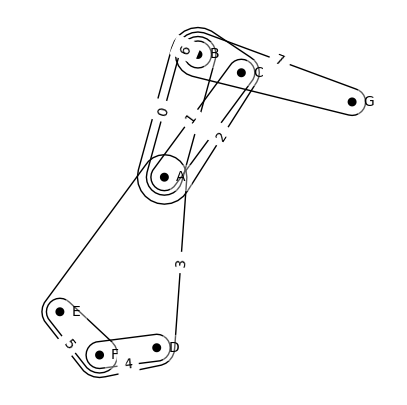

In [4]:
## build an hypergraph from a list of sets (the hyperedges)
## using 'enumerate', edges will have integer IDs
E = [{'A','B'},{'A','C'},{'A','B','C'},{'A','D','E','F'},{'D','F'},{'E','F'},{'B'},{'G','B'}]
kwargs = {'layout_kwargs': {'seed': 4321}, 'with_node_counts': False}
H = hnx.Hypergraph(dict(enumerate(E)))
for e in H.edges:
    H.edges[e].weight = 1.0
edges_kwargs={'edgecolors':'black'}
with warnings.catch_warnings(): ## matplotlib warning
    warnings.simplefilter("ignore")
    plt.figure(figsize=(5,5))
hnx.draw(H, **kwargs, edges_kwargs=edges_kwargs, edge_label_alpha=1)
#plt.savefig('h_toy_a.png')

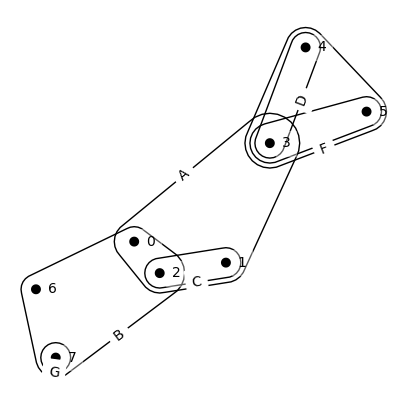

In [5]:
## dual hypergraph
H_dual = H.dual()
kwargs = {'layout_kwargs': {'seed': 123}, 'with_node_counts': False, 'with_edge_labels':True}
sizes = np.array([H_dual.size(e) for e in H_dual.edges])
norm = plt.Normalize(sizes.min(),sizes.max())
edges_kwargs={'edgecolors':'black'}
plt.figure(figsize=(5,5))
hnx.draw(H_dual, **kwargs, edges_kwargs=edges_kwargs, edge_label_alpha=1)
#plt.savefig('h_toy_b.png')


In [6]:
## show the nodes and edges
print('shape:', H.shape)
print('nodes:', [x for x in H.nodes()])
print('edges:', [x for x in H.edges()])
print('node degrees:', [(v,H.degree(v)) for v in H.nodes()])
print('edge sizes:',[H.size(e) for e in H.edges()])

shape: (7, 8)
nodes: ['B', 'A', 'C', 'D', 'E', 'F', 'G']
edges: [0, 1, 2, 3, 4, 5, 6, 7]
node degrees: [('B', 4), ('A', 4), ('C', 2), ('D', 2), ('E', 2), ('F', 3), ('G', 1)]
edge sizes: [2, 2, 3, 4, 2, 2, 1, 2]


In [7]:
## incidence dictionary
H.incidence_dict

{0: ['B', 'A'],
 1: ['C', 'A'],
 2: ['C', 'A', 'B'],
 3: ['D', 'E', 'F', 'A'],
 4: ['D', 'F'],
 5: ['E', 'F'],
 6: ['B'],
 7: ['G', 'B']}

In [8]:
## incidence matrix
df = pd.DataFrame(H.incidence_matrix().toarray(), 
                  index=[v for v in H.nodes()],
                  columns=['edge_'+str(i) for i in np.arange(0,8)])
df

,edge_0,edge_1,edge_2,edge_3,edge_4,edge_5,edge_6,edge_7
B,1,1,1,1,0,0,0,0
A,1,0,1,0,0,0,1,1
C,0,1,1,0,0,0,0,0
D,0,0,0,1,1,0,0,0
E,0,0,0,1,0,1,0,0
F,0,0,0,1,1,1,0,0
G,0,0,0,0,0,0,0,1


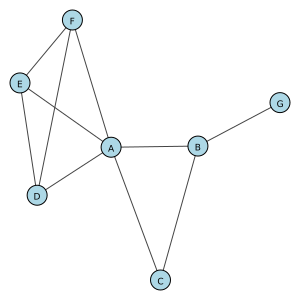

In [9]:
## 2-section graph
G = hmod.two_section(H)
ig.plot(G, bbox=(300,300),vertex_label=G.vs['name'], vertex_label_size=9, vertex_color='lightblue')
#ig.plot(G, target="h_toy_c.png", bbox=(300,300),vertex_label=G.vs['name'], vertex_label_size=9, vertex_color='white')


## s-walks and distance-based measures

We illustrate a few concepts with the toy hypergraph defined earlier.

Let H=(V,E) a hypergraph, and consider its incidence matrix $B$ defined in section 7.2. 
Consider also the dual hypergraph $H^*$, where the roles of nodes are hyperedges are swapped, 
namely the edges in $H$ are the nodes in $H^*$, 
and there is as edge two vertices in $H^*$ if the corresponding hyperedges in $H$ have a non-empty intersection.

### s-walks and distances

We define the concept of $s$-walks on a hypergraph as follows. A $s$-**walk** of length $k$ on $H$ is a sequences of edges $e_{i_0}, e_{i_1}, ..., e_{i_k}$ in $E$ such that 
all $|e_{i_{j-1}} \cap e_{i_j}| \ge s$ for $1 \le j \le k$ and all $i_{j-1} \ne i_j$.

The $s$-**distance** $d_s(e_i,e_j)$ between edges $e_i$ and $e_j$ is the length of the smallest $s$-walk between those, if it exists (else the distance is usually considered as infinity, and its inverse is set to zero).

A subset $E_s \subset E$ is an $s$-**connected component** if it is a maximal subset with as $s$-walk between all $e_i, e_j \in E_s$.
The $s$-**diameter** for $E_s$ is the maximal shortest path length between all $e_i, e_j \in E_s$.

Other concepts can also be defined using $s$-walks. For example for distinct $e_i, e_j, e_k \in E$, if there is a $s$-walk $e_i, e_j, e_k$, we say that they form an $s$-**wedge**, and if there is an $s$ walk $e_i, e_j, e_k, e_i$, we can say those form an $s$-**triangle** and from those, we can define the $s$-clustering coefficients as we saw in Section 1.11.

For **nodes**, all definitions above follow by considering the **dual** hypergraph. For example, a $s$-walk is a sequence of adjacent nodes such that each consecutive node pair in the walk share at least $s$ hyperedges; all other concepts defined above follow directly.

#### toy example

In the toy example above, with $s=2$, the sequence of edges 1-2-0 is a $s$-path since edges 1 and 2 share nodes A and C, and edges 2 and 0 share nodes A and B.

In the dual toy hypergraph, again with $s=2$, the sequence of nodes (edges in the dual) D-F-E is a $s$-path since nodes D and F are both adjacent to edges 3 and 4 in H, and nodes F and E are both adjacent to edges 3 and 5 in H. 
Another $s$-path (with $s=2$) is C-A-B.

With $s=1$, this corresponds to a walk on the (unweighted 2-section) graph, while for $s \ge 2$, this only applies to hypergraphs.

Below, we compute the distances between every pair of nodes (thus, using the $s$-walks on the dual). An infinite distance between a pair of nodes means that there is no $s$-path joining those.

We see the correspondence between the $s=1$ and graph cases; moreover in those cases, we have a single connected component since every pairs of nodes is connected by a path.

With $s=2$, we see several disconnected node pairs, so in this case, we have several $s$-connected components. From inspection of the table above, we see that nodes {A,B,C} are connected,
nodes {D,E,F} are connected; node G is then an isolated node. We verify this claim below (we also do the same with the edges, i.e. using the $s$-walk on $H$ with $s=2$)                                             

In [10]:
## distances with s=1 and s=2 and on the 2-section graph
warnings.filterwarnings('ignore')
Nodes = ['A','B','C','D','E','F','G']
L = []
for i in range(len(Nodes)-1):
    for j in np.arange(i+1,len(Nodes)):
        L.append([Nodes[i],Nodes[j],G.distances(Nodes[i],Nodes[j])[0][0],H.distance(Nodes[i],Nodes[j]),H.distance(Nodes[i],Nodes[j],s=2)])
df = pd.DataFrame(L, columns=['node1','node2','2-section','s=1','s=2'])
df

,node1,node2,2-section,s=1,s=2
0,A,B,1,1,1.0
1,A,C,1,1,1.0
2,A,D,1,1,inf
3,A,E,1,1,inf
4,A,F,1,1,inf
5,A,G,2,2,inf
6,B,C,1,1,2.0
7,B,D,2,2,inf
8,B,E,2,2,inf
9,B,F,2,2,inf


In [11]:
## s=2 components
Edges = [cc for cc in H.s_connected_components(s=2, return_singletons=True)]
Nodes = [cc for cc in H.s_connected_components(s=2, edges=False, return_singletons=True)]
print('s=2, components for the nodes:',Nodes)
print('s=2, components for the edges:',Edges)


s=2, components for the nodes: [{'C', 'B', 'A'}, {'D', 'E', 'F'}, {'G'}]
s=2, components for the edges: [{0, 1, 2}, {3, 4, 5}, {6}, {7}]


## line graph

Below we illustrate the line graph for the toy hypergraph with $s=2$.

Recall that in a line graph, the nodes are the edges in the original hypergraph, 
and an edge is draw between those if they share at least $s$ nodes in the original hypergraph.

Thus we see the connectd components as listed above.


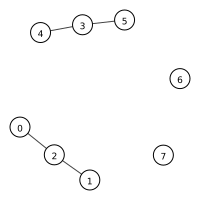

In [12]:
LG = ig.Graph.from_networkx(H.get_linegraph(s=2))
ig.plot(LG, bbox=(200,200),vertex_label=LG.vs['_nx_name'], vertex_label_size=9, vertex_color='lightgrey')
ig.plot(LG, target="h_toy_d.png", bbox=(200,200),vertex_label=LG.vs['_nx_name'], vertex_label_size=9, vertex_color='white')


##  Centrality measures

For $H=(V,E)$, we define the (un-normalized) **$s$-harmonic centrality** for edge $e_i \in E$ as:
$\frac{1}{|E|-1}\sum_{e_j \in E_s; e_i \ne e_j} \frac{1}{d_s(e_i,e_j)}$.
Recall that for $s$-disconnected edges $e_i, e_j$, we set $\frac{1}{d_s(e_i,e_j)} = 0$.

* n.b.: The HyperNetX implementation uses a different normalization when set to 'True', namely $(|E|-1)(|E|-2)/2$.

For nodes, the definition is identical using the dual hypergraph.
For our toy example, with $s=2$, nodes {A,B,C} form a connected connected component as we saw earlier, same
for nodes {D,E,F}, while node G is an isolated node.

Looking at the table of distances we computed earlier, we see that $d_2(A,B)=d_2(A,C)=1$ and $d_2(B,C)$=2,
so before normalization, the harmonic centrality for A is 2, and for B and C it is 1.5.
Results are comparable for the other connected component, with values of 1.5 for nodes D and E, and 2 for node F.
Node G is isolated and thus has zero harmonic centrality.

We can also define $s$-**betweenness centrality** as we did for graphs, namely for edge $e_i \in E$:

$\frac{1}{(|E|-1)(|E|-2)}\sum_{e_j \in E-\{e_i\}} \sum_{e_k \in E-\{e_i, e_j\}} \frac{\ell(e_j,e_k,e_i)}{\ell(e_j,e_k)}$

where: $\ell(e_j,e_k)$ is the number of shortest $s$-paths between $e_j$ and $e_k$, 
and $\ell(e_j,e_k,e_i)$ is the number of shortest $s$-paths between $e_j$ and $e_k$ that include $e_i$.
Again the definition is the same for nodes using the dual hypergraph.

For our toy example, with $s=2$, the only nodes that are on shortest $s$-paths between other nodes are nodes A (between B and C)
and node F (between D and E), thus the results we see below.

Other distance-based centrality measures can be defined for hypergraphs in the same way, using $s$-distances,
including the measures we covered in Section 3.3. 
In the example below, we also show **closeness centrality**; note that by default, the computation is done separately for each $s$-connected component, thus the results below.
Computing **eccentricity** with $s=2$ returns an error since some node are not connected, so we show the results for $s=1$.


In [13]:
## eccentricity - this yields an error with s > 1
hnx.algorithms.s_eccentricity(H, edges=False, s=1)

{'A': 2, 'B': 2, 'C': 2, 'D': 3, 'E': 3, 'F': 3, 'G': 3}

In [14]:
## centralities for 's=2'
s = 2

hc = hnx.algorithms.s_harmonic_centrality(H, edges=False, s=s, normalized=False)
bc = hnx.algorithms.s_betweenness_centrality(H, edges=False, s=s, normalized=False)
cc = hnx.algorithms.s_closeness_centrality(H, edges=False, s=s)

## normalize w.r.t. definition in the book
D = pd.DataFrame([[v,hc[v]/(H.nodes.dataframe.shape[0]-1),2*bc[v]/((H.nodes.dataframe.shape[0]-1)*(H.nodes.dataframe.shape[0]-2)),cc[v]] for v in H.nodes], columns=['node','harmonic','betweenness','closeness'])

#print(D.sort_values('harmonic', ascending=False).to_latex())
D.sort_values('harmonic', ascending=False)


,node,harmonic,betweenness,closeness
1,A,0.333333,0.066667,1.000000
5,F,0.333333,0.066667,1.000000
0,B,0.250000,0.000000,0.666667
2,C,0.250000,0.000000,0.666667
3,D,0.250000,0.000000,0.666667
4,E,0.250000,0.000000,0.666667
6,G,0.000000,0.000000,0.000000


## hypergraph modularity (qH) and clustering

We compute qH on the toy graph for 4 different partitions, and using different variations for the edge contribution.

For edges of size $d$ where $c$ is the number of nodes from the part with the most representatives, we consider  variations as follows for edge contribution:

* **strict**: edges are considered only if all nodes are from the same part, with unit weight, i.e. $w$ = 1 iff $c == d$ (0 else).
* **cubic**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the cube of the number of nodes in the majority, i.e. $w = (c/d)^3$ iff $c>d/2$ (0 else).
* **quadratic**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the square of the number of nodes in the majority, i.e. $w = (c/d)^2$ iff $c>d/2$ (0 else).
* **linear**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the number of nodes in the majority, i.e. $w = c/d$ iff $c>d/2$ (0 else).
* **majority**: edges are counted only if more that half the nodes are from the same part, with unit weights, i.e. $w$ = 1 iff $c>d/2$ (0 else).

Some of the above are supplied with the `hmod` module, the **qH2** and **qH3** functions are examples of user-supplied choice.

The order above goes from only counting "pure" edges as community edges, gradually giving more weight to edges with $c>d/2$, all the way to giving the the same weights.


In [15]:
## these will be included in the next version of hmod
## square modularity 
def qH2(d,c):
    return (c/d)**2 if c > d/2 else 0
## cubic modularity
def qH3(d,c):
    return (c/d)**3 if c > d/2 else 0

## compute hypergraph modularity (qH) for the following partitions:
A1 = [{'A','B','C','G'},{'D','E','F'}]            ## good clustering, qH should be positive
A2 = [{'B','C'},{'A','D','E','F','G'}]            ## not so good
A3 = [{'A','B','C','D','E','F','G'}]              ## this should yield qH == 0
A4 = [{'A'},{'B'},{'C'},{'D'},{'E'},{'F'},{'G'}]  ## qH should be negative here

## we compute with different choices of functions for the edge contribution

print('strict edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(H,A1,hmod.strict)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(H,A2,hmod.strict)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(H,A3,hmod.strict)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(H,A4,hmod.strict)))
print('\ncubic edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(H,A1,qH3)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(H,A2,qH3)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(H,A3,qH3)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(H,A4,qH3)))
print('\nquadratic edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(H,A1,qH2)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(H,A2,qH2)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(H,A3,qH2)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(H,A4,qH2)))
print('\nlinear edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(H,A1,hmod.linear)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(H,A2,hmod.linear)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(H,A3,hmod.linear)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(H,A4,hmod.linear)))
print('\nmajority edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(H,A1,hmod.majority)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(H,A2,hmod.majority)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(H,A3,hmod.majority)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(H,A4,hmod.majority)));


strict edge contribution:
qH(A1): 0.3659 qH(A2): -0.0401 qH(A3): 0.0000 qH(A4): -0.1088

cubic edge contribution:
qH(A1): 0.3659 qH(A2): -0.0538 qH(A3): 0.0000 qH(A4): -0.1291

quadratic edge contribution:
qH(A1): 0.3615 qH(A2): -0.0563 qH(A3): 0.0000 qH(A4): -0.1384

linear edge contribution:
qH(A1): 0.3535 qH(A2): -0.0586 qH(A3): 0.0000 qH(A4): -0.1520

majority edge contribution:
qH(A1): 0.3394 qH(A2): -0.0602 qH(A3): 0.0000 qH(A4): -0.1721


### weighted 2-section graph

We build the 2-section graph for the above toy hypergraph, and run some graph custering on this graph.

We see different edge weights.

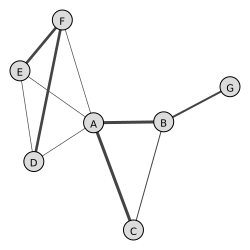

In [16]:
## 2-section graph
G = hmod.two_section(H)
G.vs['label'] = G.vs['name']
ig.plot(G, bbox=(0,0,250,250), edge_width = 2*np.array(G.es['weight']), 
        vertex_color='gainsboro', vertex_label_size=10)


In [17]:
## 2-section clustering with Leiden
G.vs['community'] = G.community_leiden(objective_function='modularity', weights='weight').membership
print('clusters:',hmod.dict2part({v['name']:v['community'] for v in G.vs}))


clusters: [{'C', 'A', 'G', 'B'}, {'D', 'E', 'F'}]


In [18]:
## Kumar clustering
cl = hmod.kumar(H)
cl

[{'A', 'B', 'C', 'G'}, {'D', 'E', 'F'}]

## Simplicial ratio

For the same toy graph, but we remove the singleton edge {'B'}.

First, we see a simplicial ratio slightly above 1, and we also see that the two simplicial pairs between 2-edges and 4-edges are more surprising that the two pairs between 2-edges and 3-edges.


In [19]:
## toy example without the singleton edge
vertices = [v for v in H.nodes()]
edges = [{'A','B'},{'A','C'},{'A','B','C'},{'A','D','E','F'},{'D','F'},{'E','F'},{'G','B'}]

## simplicial ratio
random.seed(123)
spl.get_simplicial_ratio(vertices, edges, samples=1000)


1.4179369018078694

In [20]:
## simplicial matrix
random.seed(123)
spl.get_simplicial_matrix(vertices, edges, samples=1000)


array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 2.2246941 , 1.13571834],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [21]:
## number of simplicial pairs
spl.get_simplicial_pairs(vertices, edges, as_matrix=True)

array([[0., 0., 0., 0.],
       [0., 0., 2., 2.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Other simpliciality measures

* no 3+ edge has downward closure, so the fraction is 0
* edit simpliciality is 7/16, since 9 edges would need to be added to get downward closures
* face edit simpliciality: the two values for maximal edges are 3/4 and 3/11
    

In [23]:
print('Simplicial fraction:',spl.get_simplicial_fraction(vertices, edges))
print('Edit simpliciality bis:',spl.get_edit_simpliciality(vertices, edges))
print('Face edit simpliciality:',spl.get_face_edit_simpliciality(vertices, edges, exclude_self=True))

Simplicial fraction: 0.0
Edit simpliciality bis: 0.4375
Face edit simpliciality: 0.43333333333333335


# h-ABCD Examples

The first small h-ABCD hypergraph we use next was generated as follows:

`julia --project abcdh.jl -n 100 -d 2.5,3,10 -c 1.5,30,40 -x .2 -q 0,.3,.4,.3 -w :strict -s 123 -o toy_100`

It has 100 nodes and 3 well-defined communities. We will use this example mainly for visualization.

The second one, which is much more noisy, was generated as follows:

`julia --project abcdh.jl -n 300 -d 2.5,5,30 -c 1.5,80,120 -x .6 -q 0,0,.1,.9 -w :strict -s 123 -o toy_300`

We will use this example to show that optimizing the appropriate hypergraph modularity function can lead to better clustering in some cases.
    

## 100-node h-ABCD - visualization

In [27]:
## read the edges and build the h-ABCD hypergraph H
fp = open(datadir+'ABCD/toy_100_he.txt', 'r')

Lines = fp.readlines()
Edges = []
for line in Lines:
    #Edges.append(set([int(x)-1 for x in line.strip().split(',')]))
    Edges.append(set([x for x in line.strip().split(',')]))
H = hnx.Hypergraph(dict(enumerate(Edges)))
print('distribution of edge sizes:',Counter([len(x) for x in Edges]))


distribution of edge sizes: Counter({2: 70, 3: 59, 4: 31})


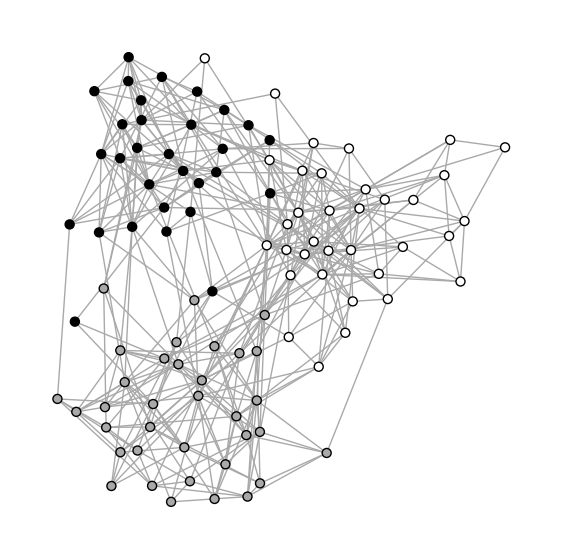

In [28]:
## read the ground-truth communities and assign node colors accordingly
H_comm = {str(k+1):v for k,v in enumerate(pd.read_csv(datadir+'ABCD/toy_100_assign.txt', header=None)[0].tolist())}
cls = ['white','darkgrey','black']
node_colors = dict(zip(H.nodes, [cls[H_comm[i]-1] for i in H.nodes]))

## build the 2-section graph and plot (with ground-truth community colors)
g = hmod.two_section(H)
for v in g.vs:
    v['color'] = node_colors[v['name']]
    v['gt'] = H_comm[v['name']]
    
random.seed(12345)
ly = g.layout_fruchterman_reingold()
g.vs['ly'] = [x for x in ly]
fig, ax = plt.subplots(figsize=(7,7))
ig.plot(g, target=ax, vertex_size=9, layout=ly, edge_color='darkgrey', edge_width=1);
#fig.savefig('habcd_1.pdf');


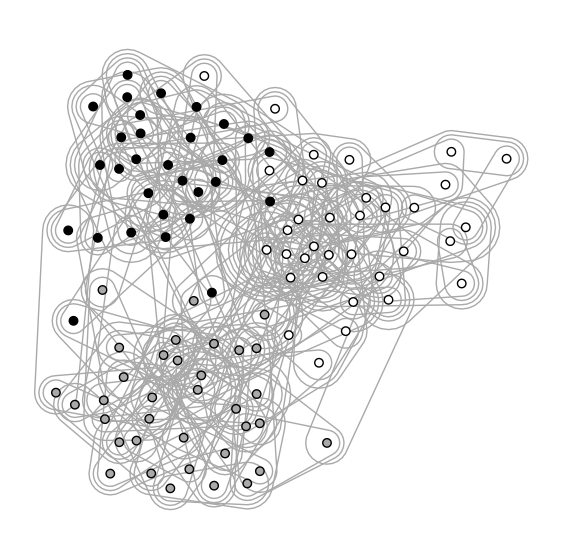

In [29]:
## rubber band plot
H_ly = dict(zip(g.vs['name'], [[x[0],x[1]] for x in g.vs['ly']]))
fig, ax = plt.subplots(figsize=(7,7))
hnx.draw(H, with_node_labels=False, with_edge_labels=False, node_radius=.67, with_node_counts=False,
         nodes_kwargs={'facecolors': node_colors, 'edgecolors' : 'black'},
         edges_kwargs={'edgecolors': 'darkgrey'},
         pos=H_ly)
#fig.savefig('habcd_2.pdf');


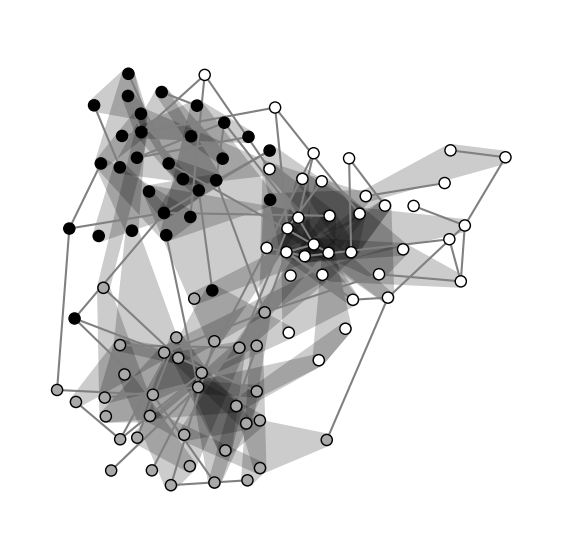

In [30]:
### Plot via convex hull
H_nc = dict(zip(g.vs['name'], g.vs['color']))
fig, ax = plt.subplots(figsize=(7,7))
XH = xgi.Hypergraph(Edges)
xgi.draw(XH, node_fc=H_nc, dyad_color='grey', hull=True, radius=.15, edge_fc_cmap='Greys_r', alpha=.2, pos=H_ly, node_size=8, ax=ax, node_labels=False );
#fig.savefig('habcd_3.pdf');


### Edge composition

Recall we call a $d$-edge a **community** edge if $c>d/2$ where $c$ is the number of nodes that belong to the most represented community.

Below we show the number of edges with all values $d$ and $c$, community edges or not.
We see that given the ground-truth communities, most community edges are *pure* in the sense that $c=d$.

In real examples, we usually do not know the ground-truth communities, or at least not for every node.
We can try some clustering, for example graph clustering on the 2-section graph, or Kumar's algorithm on the hypergraph, to get a sense of edge composition.

The result is quite similar to the ground-truth.


In [31]:
## edge composition - ground truth
L = []
for e in H.edges:
    L.append((Counter([H_comm[i] for i in H.edges[e]]).most_common(1)[0][1],len(H.edges[e])))
X = Counter(L).most_common()

L = []
for x in X:
    L.append([x[0][1], x[0][0], x[0][0]>x[0][1]/2, x[1]])
D = pd.DataFrame(np.array(L), columns=['d','c','community edge','frequency (ground truth)'])
D = D.sort_values(by=['d','c'], ignore_index=True)

## 2-section
g.vs['leiden'] = g.community_leiden(objective_function='modularity', weights='weight').membership
leiden = dict(zip(g.vs['name'],g.vs['leiden']))
L = []
for e in H.edges:
    L.append((Counter([leiden[i] for i in H.edges[e]]).most_common(1)[0][1],len(H.edges[e])))
X = Counter(L).most_common()
L = []
for x in X:
    L.append([x[0][1], x[0][0], x[0][0]>x[0][1]/2, x[1]])
D2 = pd.DataFrame(np.array(L), columns=['d','c','community edge','frequency (Leiden)'])
D2 = D2.sort_values(by=['d','c'], ignore_index=True)

D['frequency (Leiden)'] = D2['frequency (Leiden)']
D = D.sort_values('frequency (ground truth)', ascending=False)
#print(D[['d','c','frequency (ground truth)','frequency (Leiden)']].to_latex(index=False))
D

,d,c,community edge,frequency (ground truth),frequency (Leiden)
1,2,2,1,54,53
4,3,3,1,47,44
7,4,4,1,21,17
0,2,1,0,16,17
3,3,2,1,9,13
6,4,3,1,6,5
5,4,2,0,4,9
2,3,1,0,3,2


### simpliciality

We show some measures of simpliciality, namely the number of simplicial pairs, the simpliciality matrix and the simplicial ratio measure.

The simplicial ratio value is around 0.8 (recall it is based on sampling), which indicates that this hypergraph does not exhibit high simpliciality.


In [32]:
E = [set(H.edges[e]) for e in H.edges]
V = list(set([x for y in E for x in y]))
spl.get_simplicial_pairs(V, E, as_matrix=True)

array([[0., 0., 0., 0.],
       [0., 0., 5., 4.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [33]:
spl.get_simplicial_matrix(V, E, samples=1000)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.54130703, 1.15240565],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [34]:
spl.get_simplicial_ratio(V, E, samples=1000)

1.3361045130641331

In [36]:
## other measures of simpliciality
print('Simplicial fraction:',spl.get_simplicial_fraction(V,E))
print('Edit simpliciality:',spl.get_edit_simpliciality(V,E))
print('Face edit simpliciality:',spl.get_face_edit_simpliciality(V,E,exclude_self=True))

Simplicial fraction: 0.0
Edit simpliciality: 0.2568218298555377
Face edit simpliciality: 0.02296296296296296


# 300-node noisy h-ABCD

This is a noisier hypergraph with $\xi=0.6$, edges mostly of size 4 and some edges of size 3.

In the experiment below, we run each of the following algorithms 30 times and compare AMI with the ground-truth communities.
* Leiden on 2-section (weighted) graph
* Kumar's algorithm
* Kumar's algorithm followed by 1 round trying to heuristically improve strict h-modularity

We observe that Kumar's algorithm, which does take the hypergraph structure into account, slightly improves on the results with 2-section clustering, and heuristically improving the strict modularity further improves on the result of Kumar's algorithm.


In [37]:
## read the edges and build the h-ABCD hypergraph H
fp = open(datadir+'ABCD/toy_300_he.txt', 'r')
Lines = fp.readlines()
Edges = []
for line in Lines:
    Edges.append(set([x for x in line.strip().split(',')]))
H = hnx.Hypergraph(dict(enumerate(Edges)))

## read the ground-truth communities and assign node colors accordingly
H_comm = {str(k+1):v for k,v in enumerate(pd.read_csv(datadir+'ABCD/toy_300_assign.txt', header=None)[0].tolist())}

## build the 2-section graph
g = hmod.two_section(H)
for v in g.vs:
    v['gt'] = H_comm[v['name']]


In [38]:
## reduce the number of repeats (REP) for a faster run (we used REP=30 for the book)
REP = 30
L = []
random.seed(321)
np.random.seed(321) 

for s in range(30):
    g.vs['leiden'] = g.community_leiden(objective_function='modularity',weights='weight').membership
    ami_g = AMI(g.vs['gt'], g.vs['leiden'])
    H_kumar = hmod.kumar(H)
    H_kumar_dict = hmod.part2dict(H_kumar)
    ami_k = AMI([H_comm[v] for v in H.nodes], [H_kumar_dict[v] for v in H.nodes])
    H_ls = hmod.part2dict(hmod.last_step(H, H_kumar, hmod.strict))
    ami_ls = AMI([H_comm[v] for v in H.nodes], [H_ls[v] for v in H.nodes])
    L.append([ami_g, ami_k, ami_ls])
        
D = pd.DataFrame(L, columns=['2-section', 'Kumar', 'h-modularity'])
print('median values:\n')
print(D.median())

median values:

2-section       0.562565
Kumar           0.640578
h-modularity    0.779293
dtype: float64


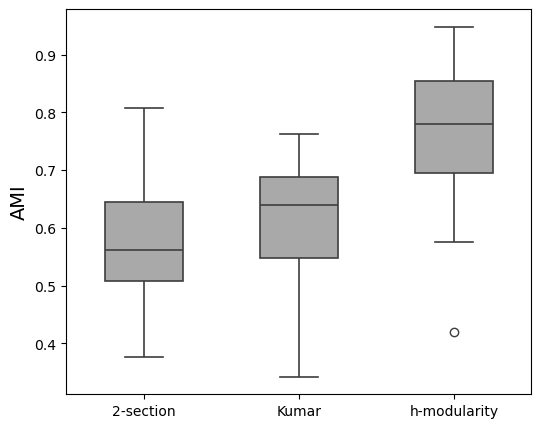

In [39]:
plt.figure(figsize=(6,5))
sns.boxplot(D, width=.5, color='darkgray', linewidth=1.2)
plt.ylabel('AMI', fontsize=14);
#plt.savefig('habcd_cluster.eps')   

In [40]:
## no simplicial pair in this case
E = [set(H.edges[e]) for e in H.edges]
V = list(set([x for y in E for x in y]))
spl.get_simplicial_pairs(V, E, as_matrix=True)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [42]:
## other measures
print('Simplicial fraction:',spl.get_simplicial_fraction(V,E))
print('Edit simpliciality:',spl.get_edit_simpliciality(V,E))
print('Face edit simpliciality:',spl.get_face_edit_simpliciality(V,E,exclude_self=True))

Simplicial fraction: 0.0
Edit simpliciality: 0.103199639477242
Face edit simpliciality: 0.0


## Embeddings

We fit two embeddings to the h-ABCD graph, namely:
* 2-section node2vec
* bipartite node2vec (we ignore the edge embeddings)

We fit a classifier where we train on 50% of the points, and test on the rest,
after reducing to 16-dim via UMAP.


Reading graph:   0%|          | 0/3593 [00:00<?, ?it/s]

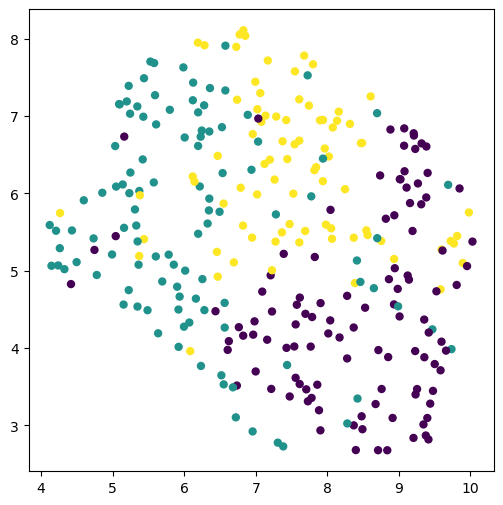

In [43]:
## 2-section
graph = n2v.Graph(g.to_tuple_list(), directed=False, weighted=False)
nv = n2v.Node2Vec(graph, dim=32, p=1, q=1, walk_length=80, window=5, seed=123)
nv.train(epochs=10, verbose=False)
X_twosec = np.array([nv.wv[i] for i in range(len(nv.wv))])

## 2-section - 2-d viz
U = umap.UMAP().fit_transform(X_twosec)
df = pd.DataFrame(U, columns=['X','Y'])
plt.figure(figsize=(6,6))
plt.scatter(df.X, df.Y, c=g.vs['gt'], s=25);


Reading graph:   0%|          | 0/2656 [00:00<?, ?it/s]

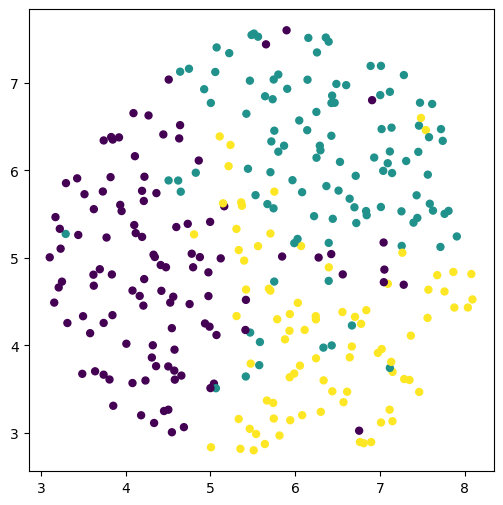

In [44]:
## bipartite (edges are in first positions; we ignore the edges)
G = ig.Graph.from_networkx(H.bipartite())
graph = n2v.Graph(G.to_tuple_list(), directed=False, weighted=False)
nv = n2v.Node2Vec(graph, dim=32, p=1, q=1, walk_length=80, window=5, seed=123)
nv.train(epochs=10, verbose=False)
n_edges = len([e for e in H.edges()])
X_bip = np.array([nv.wv[i] for i in range(len(nv.wv))])[n_edges:]

## bipartite 2-d viz
U = umap.UMAP().fit_transform(X_bip)
df = pd.DataFrame(U,columns=['X','Y'])
plt.figure(figsize=(6,6))
plt.scatter(df.X, df.Y, c=g.vs['gt'], s=25);


## fit a classifier

We train on half the data chosen at random, which we repeat 30 times.



In [45]:
## classifier - with 2-section and bipartite embeddings

acc = []
acc_b = []
y = label = g.vs['gt']

for seed in np.arange(0,301,10):
    
    ## 2-section
    X = umap.UMAP(n_components=16, n_jobs=1, random_state=seed).fit_transform(X_twosec)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
    model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt', random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    acc.append(sum(cm.diagonal())/sum(sum(cm)))

    ## bipartite - same seed
    X = umap.UMAP(n_components=16, n_jobs=1, random_state=seed).fit_transform(X_bip)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
    model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt', random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    acc_b.append(sum(cm.diagonal())/sum(sum(cm)))
    
print(np.mean(acc), np.mean(acc_b))

0.8150537634408604 0.8670967741935485


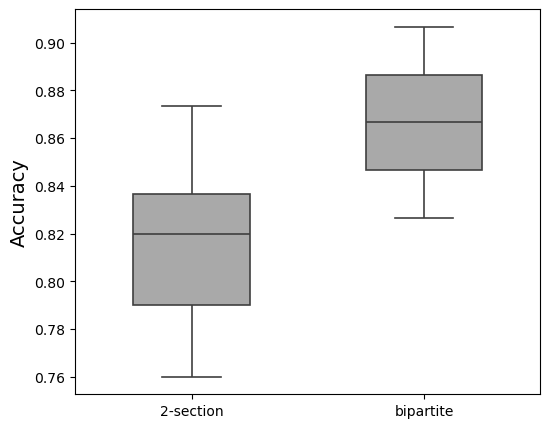

In [46]:
D = pd.DataFrame(np.array([acc,acc_b]).transpose(),columns=['2-section','bipartite'])
plt.figure(figsize=(6,5))
sns.boxplot(D, width=.5, color='darkgray', linewidth=1.2);
plt.ylabel('Accuracy', fontsize=14);
#plt.savefig('habcd_classify.eps')

# Game of Thrones scenes hypergraph

The original data can be found here: https://github.com/jeffreylancaster/game-of-thrones.
A pre-processed version is provided, where we consider an hypergraph from the game of thrones scenes with he following elements:

* **Nodes** are named characters in the series
* **Hyperedges** are groups of character appearing in the same scene(s)
* **Hyperedge weights** are total scene(s) duration in seconds involving each group of characters

We kept hyperedges with at least 2 characters and we discarded characters with degree below 5.

We saved the following:

* *Edges*: list of sets where the nodes are 0-based integers represented as strings: '0', '1', ... 'n-1'
* *Names*: dictionary; mapping of nodes to character names
* *Weights*: list; hyperedge weights (in same order as Edges)


In [47]:
## read the data
with open(datadir+"GoT/GoT.pkl","rb") as f:
    Edges, Names, Weights = pickle.load(f)


## Build the weighted hypergraph 

Use the above to build the weighted hypergraph (GoT).

In [48]:
## Nodes are represented as strings from '0' to 'n-1'
GoT = hnx.Hypergraph(dict(enumerate(Edges)))


In [49]:
## add full names of characters and compute node strength (a.k.a. weighted degree)
I, _node, _edge = GoT.incidence_matrix(index=True)
S = I * [Weights[int(i)] for i in _edge]
Strength = {i:j for i,j in zip(_node,S)}
for v in GoT.nodes:
    GoT.nodes[v].name = Names[v]
    GoT.nodes[v].strength = Strength[v]
for e in GoT.edges:
    GoT.edges[e].weight = Weights[e]

## EDA on the GoT hypergraph

Simple exploratory data analysis (EDA) on this hypergraph. 

max edge size: 24
median edge size: 3.0


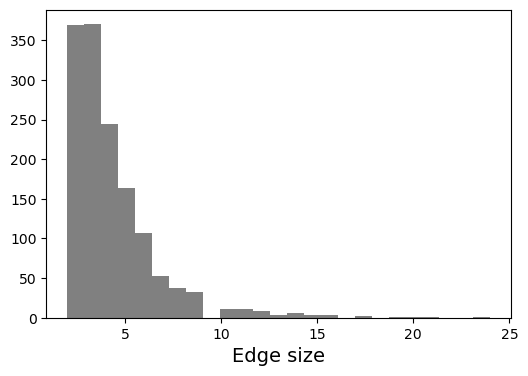

In [50]:
## edge sizes (number of characters per scene)
plt.figure(figsize=(6,4))
plt.hist([GoT.size(e) for e in GoT.edges], bins=25, color='grey')
plt.xlabel("Edge size", fontsize=14);
#plt.savefig('got_hist_1.eps');

## max edge size
print('max edge size:', np.max([GoT.size(e) for e in GoT.edges]))
print('median edge size:', np.median([GoT.size(e) for e in GoT.edges]))

max edge weight: 2995
median edge weight: 72.0


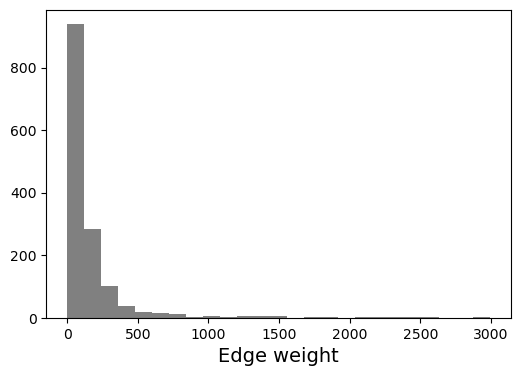

In [51]:
## edge weights (total scene durations for each group of characters appearing together)
plt.figure(figsize=(6,4))
plt.hist([Weights], bins=25, color='grey')
plt.xlabel("Edge weight",fontsize=14);
#plt.savefig('got_hist_2.eps');

## max/median edge weight
print('max edge weight:', np.max([Weights]))
print('median edge weight:', np.median([Weights]))

max node degree: 306
median node degree: 17.0


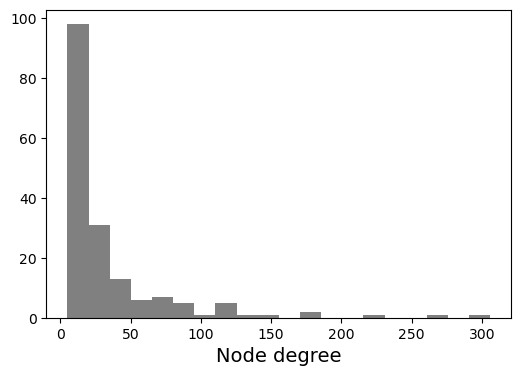

In [52]:
## node degrees
plt.figure(figsize=(6,4))
plt.hist(hnx.degree_dist(GoT),bins=20, color='grey')
plt.xlabel("Node degree",fontsize=14);
#plt.savefig('got_hist_3.eps');

## max degree
print('max node degree:', np.max(hnx.degree_dist(GoT)))
print('median node degree:', np.median(hnx.degree_dist(GoT)))

max node strength: 39899
median node strength: 2195.0


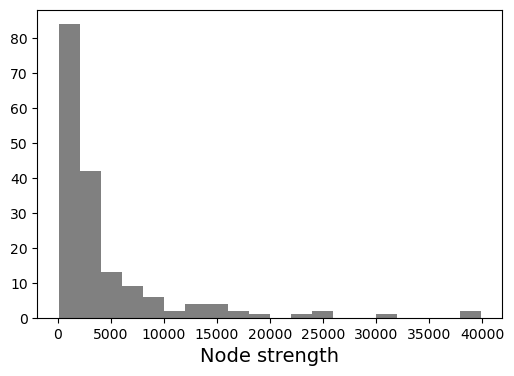

In [53]:
## node strength (total scene appearance)
plt.figure(figsize=(6,4))
plt.hist([GoT.nodes[n].strength for n in GoT.nodes], bins=20, color='grey')
plt.xlabel("Node strength",fontsize=14);
#plt.savefig('got_hist_4.eps');

## max strength
print('max node strength:', np.max([GoT.nodes[n].strength for n in GoT.nodes]))
print('median node strength:', np.median([GoT.nodes[n].strength for n in GoT.nodes]))

In [54]:
## build a dataframe with node characteristics
df = pd.DataFrame()
df['name'] = [GoT.nodes[v].name for v in GoT.nodes()]
df['degree'] = [GoT.degree(v) for v in GoT.nodes()]
df['strength'] = [GoT.nodes[v].strength for v in GoT.nodes()]
df.sort_values(by='strength',ascending=False).head(12)

,name,degree,strength
54,Tyrion Lannister,263,39899
11,Jon Snow,306,39221
9,Daenerys Targaryen,220,30644
36,Sansa Stark,183,25009
7,Cersei Lannister,184,24981
1,Jaime Lannister,153,22741
18,Jorah Mormont,118,19344
37,Arya Stark,103,17775
53,Davos Seaworth,131,16960
52,Lord Varys,115,15615


###  Compute s-centrality and betweenness

In [55]:
%%time

## with s=1
bet = hnx.s_betweenness_centrality(GoT, edges=False)
har = hnx.s_harmonic_centrality(GoT, edges=False, normalized=True)
df['betweenness(s=1)'] = [bet[v] for v in GoT.nodes()]
df['harmonic(s=1)'] = [har[v] for v in GoT.nodes()]

## with s=2
bet = hnx.s_betweenness_centrality(GoT, edges=False, s=2)
har = hnx.s_harmonic_centrality(GoT, edges=False, normalized=True, s=2)
df['betweenness(s=2)'] = [bet[v] for v in GoT.nodes()]
df['harmonic(s=2)'] = [har[v] for v in GoT.nodes()]

#print(df.sort_values(by=['strength'],ascending=False).head(10)[['name','degree','strength','betweenness(s=1)','harmonic(s=1)']].to_latex(index=False, float_format="{:0.5f}".format))
df.sort_values(by=['harmonic(s=1)'],ascending=False).head(10)


CPU times: user 486 ms, sys: 37 μs, total: 486 ms
Wall time: 486 ms


,name,degree,strength,betweenness(s=1),harmonic(s=1),betweenness(s=2),harmonic(s=2)
11,Jon Snow,306,39221,0.083826,0.009010,0.108906,0.008511
54,Tyrion Lannister,263,39899,0.072250,0.009010,0.079845,0.008364
36,Sansa Stark,183,25009,0.045570,0.008806,0.066606,0.008364
1,Jaime Lannister,153,22741,0.069752,0.008806,0.101996,0.008296
37,Arya Stark,103,17775,0.104253,0.008500,0.126550,0.007865
13,Sandor Clegane,95,13150,0.030606,0.008364,0.032004,0.007820
23,Bran Stark,125,13943,0.029062,0.008296,0.058049,0.007775
52,Lord Varys,115,15615,0.023299,0.008262,0.018840,0.007741
7,Cersei Lannister,184,24981,0.021079,0.008183,0.027025,0.007695
53,Davos Seaworth,131,16960,0.031404,0.008160,0.031259,0.007661


## Build 2-section graph and compute a few centrality measures

We saw several centrality measures for graphs in chapter 3. 

Below, we build the 2-section graph for GoT and compute a few of those. 

**Unlike in the first edition of the book, we now ignore edge weights to compare with the hypergraph s-measures.**


In [56]:
## build 2-section
G = hmod.two_section(GoT)

## betweenness
n = G.vcount()
b = G.betweenness(directed=False)
G.vs['bet'] = [2*x/((n-1)*(n-2)) for x in b]
for v in G.vs:
    GoT.nodes[v['name']].bet = v['bet']
df['betweenness'] = [GoT.nodes[v].bet for v in GoT.nodes()]

## harmonic
G.vs['hc'] = G.harmonic_centrality(normalized=True)
for v in G.vs:
    GoT.nodes[v['name']].hc = v['hc']
df['harmonic'] = [GoT.nodes[v].hc for v in GoT.nodes()]

## order w.r.t. harmonic
df.sort_values(by='harmonic',ascending=False).head()


,name,degree,strength,betweenness(s=1),harmonic(s=1),betweenness(s=2),harmonic(s=2),betweenness,harmonic
11,Jon Snow,306,39221,0.083826,0.009010,0.108906,0.008511,0.083826,0.770349
54,Tyrion Lannister,263,39899,0.072250,0.009010,0.079845,0.008364,0.072250,0.770349
36,Sansa Stark,183,25009,0.045570,0.008806,0.066606,0.008364,0.045570,0.752907
1,Jaime Lannister,153,22741,0.069752,0.008806,0.101996,0.008296,0.069752,0.752907
37,Arya Stark,103,17775,0.104253,0.008500,0.126550,0.007865,0.104253,0.726744


In [57]:
## high correlation between centrality measures
corr = df[['betweenness(s=1)','betweenness(s=2)','betweenness','harmonic(s=1)','harmonic(s=2)','harmonic']].corr()
#print(corr[['harmonic','betweenness']].to_latex(index=True,  float_format="{:0.3f}".format))
print(corr[['harmonic','betweenness']])

                  harmonic  betweenness
betweenness(s=1)  0.744945     1.000000
betweenness(s=2)  0.710771     0.980122
betweenness       0.744945     1.000000
harmonic(s=1)     1.000000     0.744945
harmonic(s=2)     0.953378     0.749892
harmonic          1.000000     0.744945


## Hypergraph modularity and clustering



nodes: 173 edges: 2226


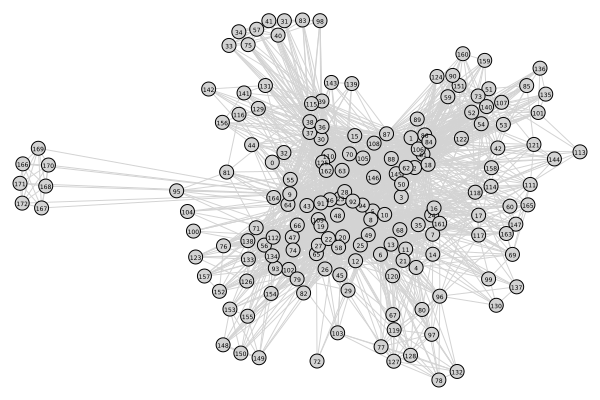

In [58]:
##### visualize the 2-section graph
print('nodes:',G.vcount(),'edges:',G.ecount())
G.vs['size'] = 14
G.vs['color'] = 'lightgrey'
G.vs['label'] = [int(x) for x in G.vs['name']] ## use int(name) as label
G.vs['character'] = [GoT.nodes[n].name for n in G.vs['name']]
G.vs['label_size'] = 6
seed = 42
np.random.seed(seed)
random.seed(seed)
ly_fr = G.layout_fruchterman_reingold()
ig.plot(G, layout=ly_fr, bbox=(0,0,600,400), edge_color='lightgrey')


In [59]:
## we see a well-separated small clique; it is the Braavosi theater troup
print([GoT.nodes[str(x)].name for x in np.arange(166,173)])


['Izembaro', 'Lady Crane', 'Camello', 'Bobono', 'Bianca', 'Clarenzo', 'Margaery Tyrell Mummer']


In [60]:
## Compute modularity (qH) on several random partition with K parts for a range of K's
## This should be close to 0 and can be negative.
h = []
for K in np.arange(2,21,2):
    for rep in range(10):
        V = list(GoT.nodes)
        np.random.seed(K*rep)
        p = np.random.choice(K, size=len(V))
        RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
        ## drop empty sets if any
        RandPart = [x for x in RandPart if len(x)>0]
        ## compute qH
        h.append(hmod.modularity(GoT, RandPart, qH2))
print('range for qH:',min(h),'to',max(h))


range for qH: -0.04984145360177603 to 0.044755009470384285


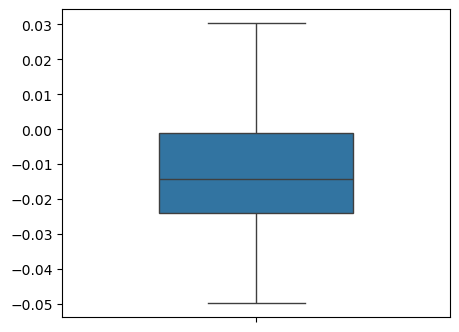

In [61]:
plt.figure(figsize=(5,4))
sns.boxplot(h, showfliers=False, width=.5);

In [62]:
## Cluster the 2-section graph (with Leiden or Louvain) and compute qH
## We now see qH >> 0
random.seed(123)
G.vs['leiden'] = G.community_leiden(objective_function='modularity', weights='weight').membership
#G.vs['leiden'] = G.community_multilevel(resolution = 10, weights='weight').membership
for v in G.vs:
    GoT.nodes[v['name']].leiden = v['leiden']
df['leiden_cluster'] = [GoT.nodes[v].leiden for v in GoT.nodes()]
ML = hmod.dict2part({v['name']:v['leiden'] for v in G.vs})
print('qH:',"{:.4f}".format(hmod.modularity(GoT, ML, qH3)))


qH: 0.5459


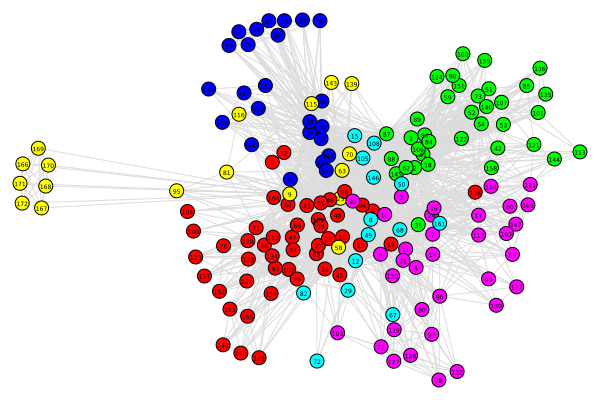

In [63]:
## plot 2-section w.r.t. the resulting clusters
cl = G.vs['leiden']

## pick greyscale or color plot:
#pal = ig.GradientPalette("white","black",max(cl)+2)
pal = ig.ClusterColoringPalette(max(cl)+2)

G.vs['color'] = [pal[x] for x in cl]
G.vs['label_size'] = 6
ig.plot(G, layout = ly_fr, bbox=(0,0,600,400), edge_color='gainsboro')
#G.vs['label_size'] = 0
#ig.plot(G, target='GoT_clusters.eps', layout = ly_fr, bbox=(0,0,600,400), edge_color='grey')


In [64]:
## ex: high strength nodes in same cluster with Daenerys Targaryen
dt = df[df['name']=='Daenerys Targaryen']['leiden_cluster'].iloc[0]
df[df['leiden_cluster']==dt].sort_values(by='strength',ascending=False).head(9)

,name,degree,strength,betweenness(s=1),harmonic(s=1),betweenness(s=2),harmonic(s=2),betweenness,harmonic,leiden_cluster
9,Daenerys Targaryen,220,30644,0.045043,0.008092,0.059555,0.007763,0.045043,0.691860,2
18,Jorah Mormont,118,19344,0.030233,0.007661,0.042852,0.007503,0.030233,0.655039,2
55,Missandei,92,13683,0.007734,0.007423,0.008928,0.007129,0.007734,0.634690,2
56,Grey Worm,79,10416,0.008742,0.007480,0.009792,0.007163,0.008742,0.639535,2
104,Barristan Selmy,35,6514,0.005789,0.006755,0.005635,0.006267,0.005789,0.577519,2
10,Drogon,84,6396,0.026363,0.007548,0.019135,0.006993,0.026363,0.645349,2
164,Daario Naharis,32,5370,0.000127,0.005542,0.000222,0.005372,0.000127,0.473837,2
14,Rhaegal,49,3932,0.016791,0.007185,0.008297,0.006539,0.016791,0.614341,2
137,Khal Drogo,14,3575,0.000007,0.005032,0.000096,0.004913,0.000007,0.430233,2


In [65]:
## last step heuristic given the 2-section Leiden partition
np.random.seed(123)
leiden = dict(zip(G.vs['name'],G.vs['leiden']))
ls = hmod.last_step(GoT, hmod.dict2part(leiden), qH2, verbose=True)
print('qH:',"{:.4f}".format(hmod.modularity(GoT, ls, qH2)))
    
ls_dict = hmod.part2dict(ls)
df['cluster_qH'] = [ls_dict[v] for v in GoT.nodes()]
G.vs['cluster_qH'] = [ls_dict[v['name']] for v in G.vs]

initial qH: 0.5444520687193962
6 moves, new qH: 0.5464118867140776
qH: 0.5464


In [66]:
## which nodes were moved?
df[df.leiden_cluster != df.cluster_qH]

,name,degree,strength,betweenness(s=1),harmonic(s=1),betweenness(s=2),harmonic(s=2),betweenness,harmonic,leiden_cluster,cluster_qH
0,Randyll Tarly,9,1157,0.000047,0.005984,0.000004,0.005451,0.000047,0.511628,0,1
2,Dickon Tarly,9,1118,0.000047,0.005984,0.000004,0.005451,0.000047,0.511628,0,1
103,Meryn Trant,30,2678,0.001623,0.006653,0.000996,0.006075,0.001623,0.568798,0,3
109,Handmaid,7,235,0.000398,0.005678,0.000033,0.005123,0.000398,0.485465,4,0
110,Ros,12,1849,0.000393,0.005916,0.000279,0.004998,0.000393,0.505814,5,0
153,Armeca,5,629,0.000013,0.005259,0.000121,0.004737,0.000013,0.449612,5,0


In [67]:
Ku = hmod.kumar(GoT, verbose=False)

In [68]:
hmod.modularity(GoT,Ku,qH3)

0.5481383131154229

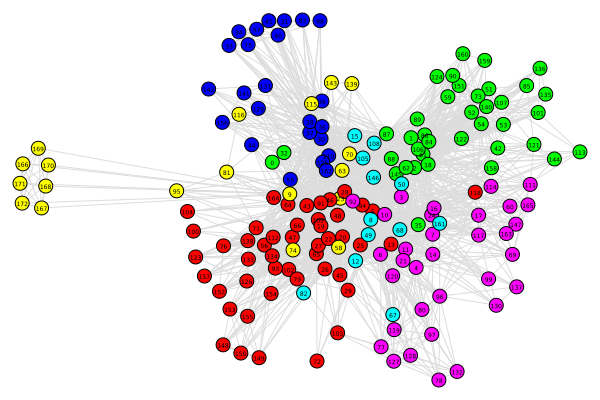

In [69]:
## plot 2-section w.r.t. the resulting clusters
cl = G.vs['cluster_qH']

## pick greyscale or color plot:
#pal = ig.GradientPalette("white","black",max(cl)+2)
pal = ig.ClusterColoringPalette(max(cl)+2)

G.vs['color'] = [pal[x] for x in cl]
ig.plot(G, layout = ly_fr, bbox=(0,0,600,400), edge_color='gainsboro')
#ig.plot(G, target='GoT_clusters.eps', layout = ly, bbox=(0,0,400,400))


### edge composition after clustering

We see that the most frequent edges are small "pure" edges; there ar ealso several edges with all but one node from the same community.


In [70]:
comm_dict = dict(zip(G.vs['name'],G.vs['cluster_qH']))
L = []
for e in GoT.edges:
    L.append(tuple(x[1] for x in Counter([comm_dict[i] for i in GoT.edges[e]]).most_common()))
X = Counter(L).most_common()
L = []
for x in X:
    L.append([len(x[0]), sum(x[0]), x[0][0], x[1], x[0][0]>sum(x[0])/2])
df_cd = pd.DataFrame(np.array(L), columns=['n_comm','d','c','frequency','community edge'],)
df_cd['cum_freq'] = df_cd.cumsum().frequency / GoT.shape[1]
#print(df_cd[['d','c','frequency']][:10].to_latex(index=False))
df_cd[:10]

,n_comm,d,c,frequency,community edge,cum_freq
0,1,2,2,240,1,0.167598
1,1,3,3,216,1,0.318436
2,2,3,2,136,1,0.413408
3,2,2,1,129,0,0.503492
4,1,4,4,123,1,0.589385
5,1,5,5,82,1,0.646648
6,2,4,3,62,1,0.689944
7,1,6,6,52,1,0.726257
8,2,5,4,36,1,0.751397
9,2,4,2,30,0,0.772346


### Compute the simplicial ratio and other simpliciality measures

We see a simpliciality ratio well above 1, suggesting more simplicial pairs than would happen at random.

For the other measures, the simplicial fraction (0.07) and more so the edit simpliciality (7e-5) are small,
which is to be expected as there are several large edges in this dataset.
The face edit sompliciality is a bit higher at 0.29.


In [71]:
%%time
## compute the simplicial ratio measure
E = [set(GoT.edges[e]) for e in GoT.edges]
V = list(set([x for y in E for x in y]))

## build list of edges incident to each node
edge_dict = spl.get_edge_sets(V, E)

## mapping between node index and character name
node_dict = dict(zip([GoT.nodes[v].name for v in GoT.nodes], list(GoT.nodes)))

## simplicial ratio
spl.get_simplicial_ratio(V, E, samples=100)


CPU times: user 755 ms, sys: 4 ms, total: 759 ms
Wall time: 759 ms


3.5496823498345735

In [72]:
print('Simplicial fraction:',spl.get_simplicial_fraction(V,E))
print('Edit simpliciality:',spl.get_edit_simpliciality(V,E))
print('Face edit simpliciality:',spl.get_face_edit_simpliciality(V, E, exclude_self=True))


Simplicial fraction: 0.07337723424270931
Edit simpliciality: 7.252739327229417e-05
Face edit simpliciality: 0.25758108816004266


### Compute the individual simpliciality ratio for each GoT character

In [67]:
## Compute the individual simpliciality ratio for each character and rank
sm = []
np.random.seed(123)
for name in df.name:
    E = edge_dict[node_dict[name]]
    V = list(set([x for y in E for x in y]))
    sm.append(spl.get_simplicial_ratio(V, E, samples=100))
df['simpliciality'] = sm
df.sort_values(by='simpliciality', ascending=False)


,name,degree,strength,betweenness(s=1),harmonic(s=1),betweenness(s=2),harmonic(s=2),betweenness,harmonic,leiden_cluster,cluster_qH,simpliciality
78,Bowen Marsh,11,1137,0.000181,0.005701,0.000104,0.005219,0.000181,0.487403,2,2,4.953560
104,Barristan Selmy,35,6514,0.005789,0.006755,0.005635,0.006267,0.005789,0.577519,3,3,4.880478
127,Ellaria Sand,35,2786,0.004929,0.006687,0.009587,0.006211,0.004929,0.571705,0,0,4.539474
77,Othell Yarwyck,19,2101,0.000473,0.005803,0.000421,0.005434,0.000473,0.496124,2,2,4.504505
91,Yoren,12,1786,0.001850,0.006437,0.000777,0.005508,0.001850,0.550388,1,1,4.432133
...,...,...,...,...,...,...,...,...,...,...,...,...
172,Margaery Tyrell Mummer,5,311,0.000000,0.005021,0.000000,0.004805,0.000000,0.429264,1,1,1.112878
125,Lady Crane,8,991,0.000000,0.005021,0.000000,0.004805,0.000000,0.429264,1,1,1.017812
171,Camello,6,540,0.000000,0.005021,0.000000,0.004805,0.000000,0.429264,1,1,1.008827
163,Captain of the Archers,6,102,0.000000,0.005304,0.000000,0.005100,0.000000,0.453488,0,0,0.897436


In [68]:
## pick high/low simpliciality nodes with low degree for viz below
hs = 'Bowen Marsh'
ls = 'Ros'


looking at node: Bowen Marsh


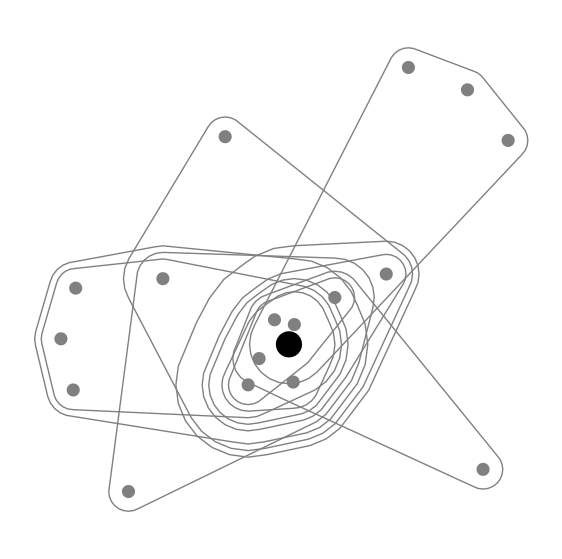

In [69]:
## high simpliciality
kwargs = {'layout_kwargs': {'seed': 123}, 'with_edge_labels':False, 'with_node_labels':False}
edges_kwargs={'edgecolors':'grey'}
SE = [e for e in edge_dict[node_dict[hs]]]
HG = hnx.Hypergraph(SE)
nc = ['grey']*len(list(HG.nodes))
idx = np.where(np.array(HG.nodes)==node_dict[hs])[0][0]
nc[idx] = 'black'
nr = dict(zip(HG.nodes,[1]*len(list(HG.nodes))))
nr[node_dict[hs]] = 2
nodes_kwargs={'facecolors':nc}
print('looking at node:',hs)
plt.subplots(figsize=(7,7))
hnx.draw(HG, **kwargs, edges_kwargs=edges_kwargs, nodes_kwargs=nodes_kwargs,  node_radius=nr)
plt.savefig('bowen.eps');


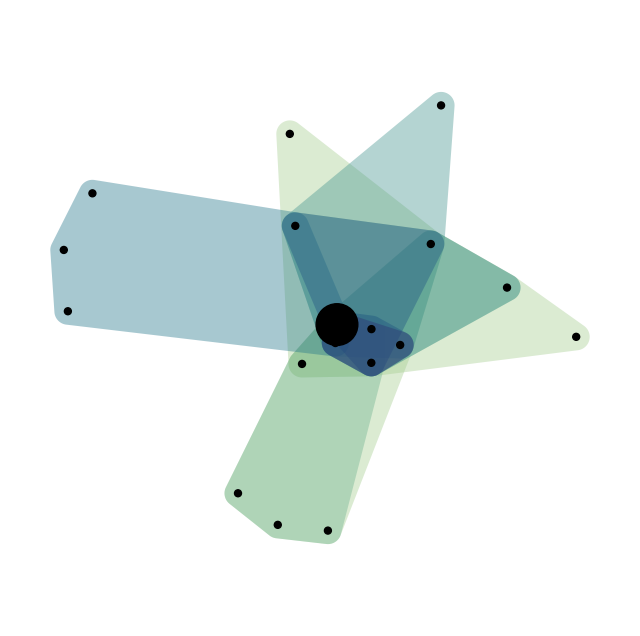

In [70]:
## convex hull view
XH = xgi.Hypergraph([list(HG.edges[e]) for e in HG.edges])
xgi.draw(XH, node_fc='black', hull=True, node_size=[nr[i] for i in XH.nodes]);


looking at node: Ros


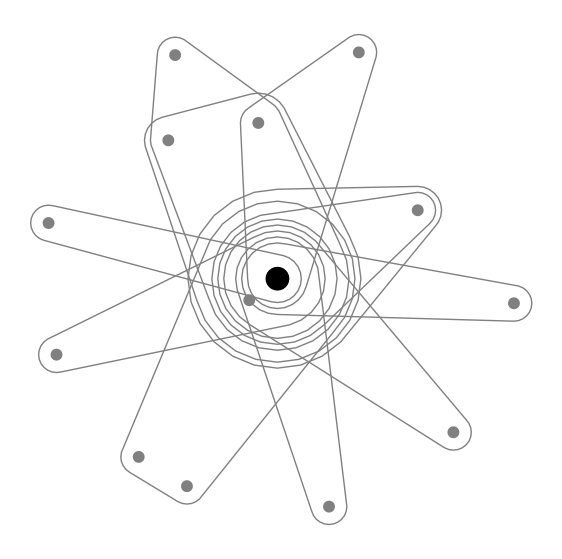

In [71]:
## low simpliciality
kwargs = {'layout_kwargs': {'seed': 123}, 'with_edge_labels':False, 'with_node_labels':False}
edges_kwargs={'edgecolors':'grey'}
SE = [e for e in edge_dict[node_dict[ls]]]
HG = hnx.Hypergraph(SE)
nc = ['grey']*len(list(HG.nodes))
idx = np.where(np.array(HG.nodes)==node_dict[ls])[0][0]
nc[idx] = 'black'
nr = dict(zip(HG.nodes,[1]*len(list(HG.nodes))))
nr[node_dict[ls]] = 2
nodes_kwargs={'facecolors':nc}
print('looking at node:',ls)
plt.subplots(figsize=(7,7))
hnx.draw(HG, **kwargs, edges_kwargs=edges_kwargs, nodes_kwargs=nodes_kwargs, node_radius=nr)
#plt.savefig('ros.eps');


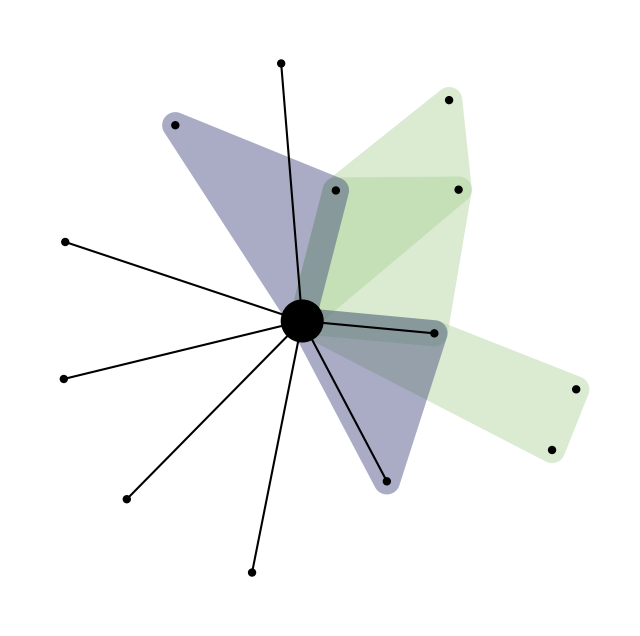

In [72]:
##convex hull view
XH = xgi.Hypergraph([list(HG.edges[e]) for e in HG.edges])
xgi.draw(XH, node_fc='black', hull=True, node_size=[nr[i] for i in XH.nodes]);


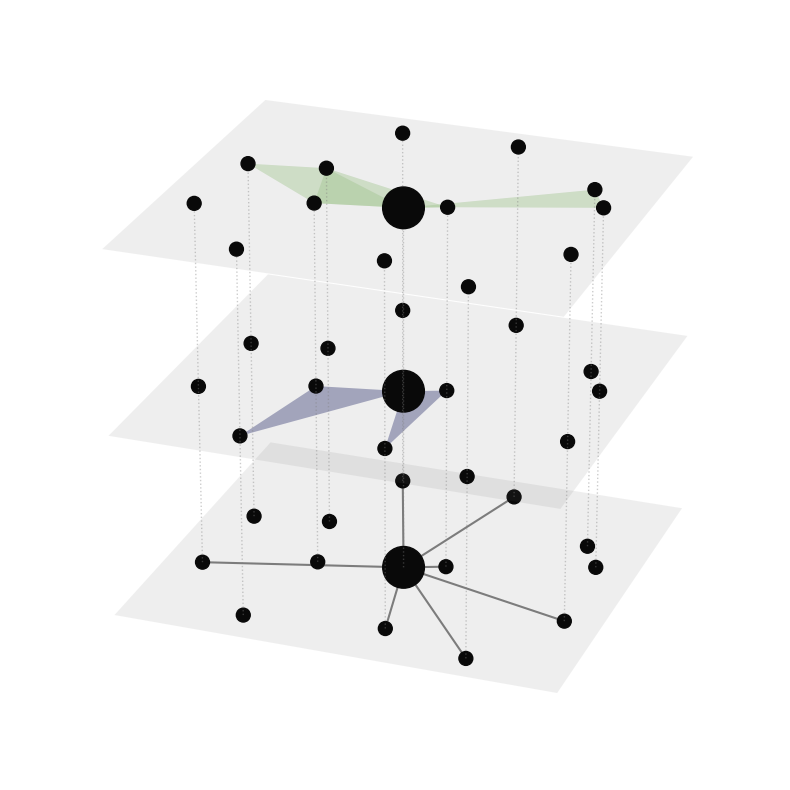

In [73]:
## 3-d view per edge size
_, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
xgi.draw_multilayer(XH, ax=ax, node_fc='black',hull=True, node_size=[nr[i] for i in XH.nodes], sep=1, h_angle=25)
plt.show()


### GoT - degree - size correlation

We see positive, but very small correlation in this case.


correlation: 0.03884883389238206


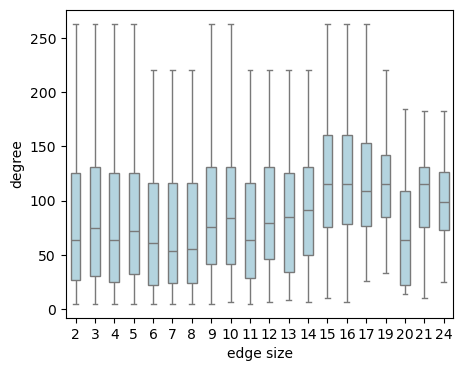

In [74]:
_x, _y, corr = h_deg_size_corr(GoT)
print('correlation:',corr)
_df = pd.DataFrame(np.array([_x, _y]).T, columns=['degree','edge size'])
plt.figure(figsize=(5,4))
sns.boxplot(data=_df, x='edge size', y='degree', showfliers=False, width=.5, color='lightblue');


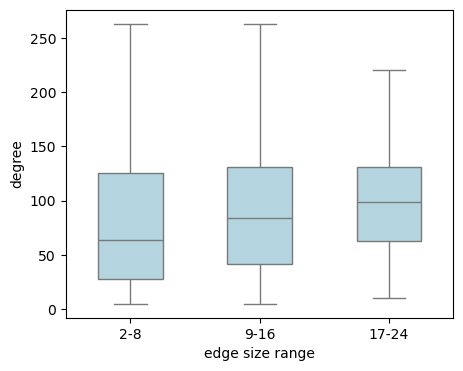

In [75]:
## grouping node sizes in 2 tiers: up to 8, 9-16 and 17+
_df['edge size range'] = [(x-1)//8 for x in _df['edge size']]
plt.figure(figsize=(5,4))
sns.boxplot(data=_df, x='edge size range', y='degree', showfliers=False, width=.5, color='lightblue')
plt.xticks([0,1,2],['2-8','9-16','17-24']);


### Rich club coefficients - via sampling for computing the denominator

* first, compute number of edges with all nodes having degree >= k for each k: $\phi(k)$


In [76]:
## degrees in GoT graph
threshold = np.quantile([GoT.degree(v) for v in GoT.nodes],.95)
d = np.sort(list(set([GoT.degree(v) for v in GoT.nodes if GoT.degree(v)<threshold])))
L = []
for e in GoT.edges:
    L.append(np.min([GoT.degree(v) for v in GoT.edges[e]]))
## compute phi's
phi = []
L = np.array(L)
for k in d:
    phi.append(sum(L>=k))


* now generate random bipartites graphs and compute all $\hat{\phi}_k$.


In [77]:
## number of repeats
REP = 100

## repeat each node w.r.t. its degree
V = []
for v in GoT.nodes:
    V.extend(list(np.repeat(v,GoT.degree(v))))

## edge sizes
S = [len(GoT.edges[e]) for e in GoT.edges()]

## initialize
np.random.seed(321)
phi_hat = np.zeros(len(phi))

for rep in range(REP):
    ## randomize   
    V = np.random.permutation(V)
    ## generate the edges
    ctr = 0
    E = []
    for s in S:
        E.append(list(V[ctr:(ctr+s)]))
        ctr += s
    ## min degree seen for each edge
    L = []
    for e in E:
        L.append(np.min([GoT.degree(v) for v in e]))
    L = np.array(L)
    ## compute one instance of phi_hat and add to the sum
    ph = []
    for k in d:
        ph.append(sum(L>=k))   
    phi_hat = phi_hat + np.array(ph)

## average the final phi_hat vector
phi_hat = phi_hat / REP


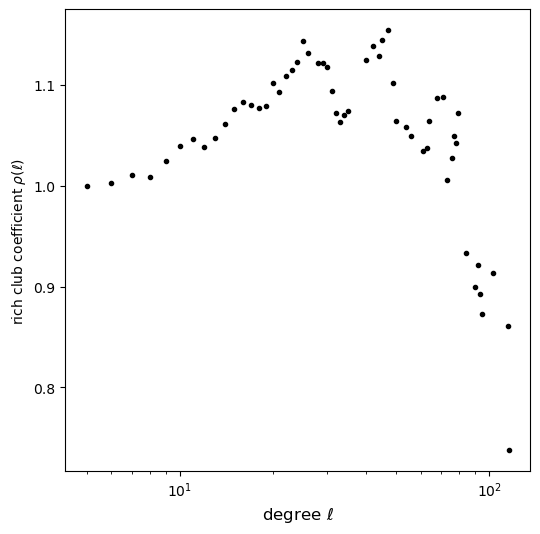

In [78]:
plt.figure(figsize=(6,6))
rc = [a/b for a,b in zip(phi,phi_hat)]
plt.semilogx(d, rc, ".", c="black")
plt.xlabel(r"degree $\ell$", fontsize=12)
plt.ylabel(r"rich club coefficient $\rho(\ell)$");
# plt.savefig('rich_club_got.eps')


# Contact hypergraphs

Primary and high school contact hypergraphs

Add: details and references.


In [79]:
## read the edges and build H
fp = open(datadir+'Contacts/hyperedges-contact-primary.txt', 'r')
Lines = fp.readlines()
E = []
for line in Lines:
    E.append(set([x for x in line.strip().split(',')]))
H = hnx.Hypergraph(dict(enumerate(E)))
V = [x for x in H.nodes]
print('SF:',spl.get_simplicial_fraction(V,E),
      '\nES:',spl.get_edit_simpliciality(V,E),
      '\nFES:',spl.get_face_edit_simpliciality(V,E))
print('simplicial ratio:',spl.get_simplicial_ratio(V,E,samples=100))

SF: 0.8470540758676351 
ES: 0.9175213057922866 
FES: 0.95064455704635
simplicial ratio: 2.6944175540496933


In [80]:
## read the edges and build H
fp = open(datadir+'Contacts/hyperedges-contact-highschool.txt', 'r')
Lines = fp.readlines()
E = []
for line in Lines:
    E.append(set([x for x in line.strip().split(',')]))
H = hnx.Hypergraph(dict(enumerate(E)))
V = [x for x in H.nodes]
print('SF:',spl.get_simplicial_fraction(V,E),
      '\nES:',spl.get_edit_simpliciality(V,E),
      '\nFES:',spl.get_face_edit_simpliciality(V,E))
print('simplicial ratio:',spl.get_simplicial_ratio(V,E,samples=100))

# ## read the ground-truth communities and assign node colors accordingly
# H_comm = {str(k+1):v for k,v in enumerate(pd.read_csv(datadir+'Contacts/labels-contact-highschool.txt', 
#                                                       header=None)[0].tolist())}
# g = hmod.two_section(H)
# pal = ig.RainbowPalette(n=12) 
# for v in g.vs:
#     v['gt'] = H_comm[v['name']]
#     v['color'] = pal.get(H_comm[v['name']])
# ig.plot(g, bbox=(300,300), vertex_size=4, edge_color='lightgray')


SF: 0.8064655172413793 
ES: 0.9270722162931341 
FES: 0.9393321276864209
simplicial ratio: 6.558216350123865


# Motifs example 

Using HNX draw function to get patterns from **Figure 7.1** in the book and count motifs reported in **Table 7.2**.

Given:
* E2: number of edges of size 2
* G(E2): graph built only with E2
* E3: edges of size 3

Compute:
* H1: number of subgraphs of 4-nodes in G(E2) with 5 edges + 6 times the number of 4-cliques in G(E2)
* H3: count pairs of edges in E3 with intersection of size 2
* H2: for each (i,j,k) in E3, count common neighbours in G(E2) for (i,j), (i,k) and (j,k) 

Random hypergraphs:
* probability for 2-edges: p2 = c/(n-1)
* probability for 3-edges to maintain expected 2-section graph degree:  p3 = (8-c)/((n-1)*(n-2)) 
* probability for 3-edges to maintain expected H-degree: p3 = (8-c)/((n-1)*(n/2-1))


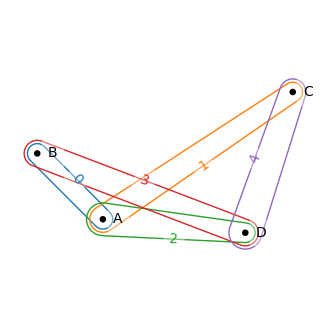

In [81]:
## H1 pattern
np.random.seed(1234)
E = [{'A','B'},{'A','C'},{'A','D'},{'B','D'},{'C','D'}]
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(4,4))
hnx.draw(HG)

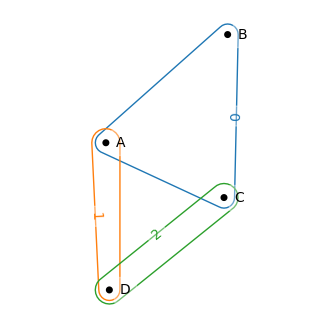

In [82]:
## H2 pattern
np.random.seed(123)
E = [{'A','B','C'},{'A','D'},{'C','D'}]
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(4,4))
hnx.draw(HG)

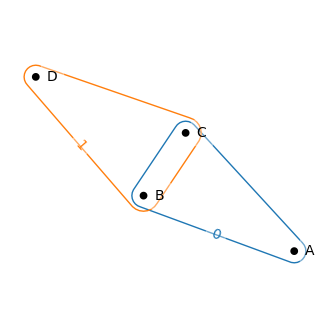

In [83]:
## H3 pattern
np.random.seed(123)
E = [{'A','B','C'},{'B','C','D'}]
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(4,4))
hnx.draw(HG)
